<a href="https://colab.research.google.com/github/SahilAliAkbar/Bharat_Intern_ML/blob/main/CNN%2CLSTM%2CDense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir

In [2]:
# Importing drive method from colab for accessing google drive
from google.colab import drive

# Mounting drive: this will require authentication : Follow the steps as guided
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# data must be downloaded and path provided
data_path = '/content/gdrive/MyDrive/Colab Notebooks/mit-bih-arrhythmia-database-1.0.0'



In [ ]:
# list of patients
pts = ['100','101','102','103','104','105','106','107',
       '108','109','111','112','113','114','115','116',
       '117','118','119','121','122','123','124','200',
       '201','202','203','205','207','208','209','210',
       '212','213','214','215','217','219','220','221',
       '222','223','228','230','231','232','233','234']

In [ ]:
import wfdb
#!pip install wfdb


In [ ]:
df = pd.DataFrame()

for pt in pts:
    file = data_path + '/'+ pt
    annotation = wfdb.rdann(file,'atr')
    sym = annotation.symbol

    values, counts = np.unique(sym, return_counts=True)
    df_sub = pd.DataFrame({'sym':values, 'val':counts, 'pt':[pt]*len(counts)})
    df = pd.concat([df, df_sub],axis = 0)


In [ ]:
df.groupby('sym').val.sum().sort_values(ascending = False)

sym
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
+     1291
f      982
F      803
~      616
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: val, dtype: int64

In [ ]:
# list of nonbeat and abnormal
nonbeat = ['[','!',']','x','(',')','p','t','u','`',
           '\'','^','|','~','+','s','T','*','D','=','"','@','Q','?']
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

In [ ]:
# break into normal, abnormal or nonbeat
df['cat'] = -1
df.loc[df.sym == 'N','cat'] = 0
df.loc[df.sym.isin(abnormal), 'cat'] = 1


In [ ]:
df.groupby('cat').val.sum()

cat
-1     3186
 0    75052
 1    34409
Name: val, dtype: int64

In [ ]:
def load_ecg(file):
    # load the ecg
    # example file: 'mit-bih-arrhythmia-database-1.0.0/101'

    # load the ecg
    record = wfdb.rdrecord(file)
    # load the annotation
    annotation = wfdb.rdann(file, 'atr')

    # extract the signal
    p_signal = record.p_signal

    # verify frequency is 360
    assert record.fs == 360, 'sample freq is not 360'

    # extract symbols and annotation index
    atr_sym = annotation.symbol
    atr_sample = annotation.sample

    return p_signal, atr_sym, atr_sample

In [ ]:
file = data_path +'/'+ pts[0]

In [ ]:
p_signal, atr_sym, atr_sample = load_ecg(file)

In [ ]:
values, counts = np.unique(sym, return_counts=True)
for v,c in zip(values, counts):
    print(v,c)


+ 3
J 50
N 2700
V 3
~ 8


In [ ]:
# get abnormal beat index
ab_index = [b for a,b in zip(atr_sym,atr_sample) if a in abnormal][:10]
ab_index


[2044, 66792, 74986, 99579, 128085, 170719, 279576, 305709, 307745, 312825]

In [ ]:
x = np.arange(len(p_signal))

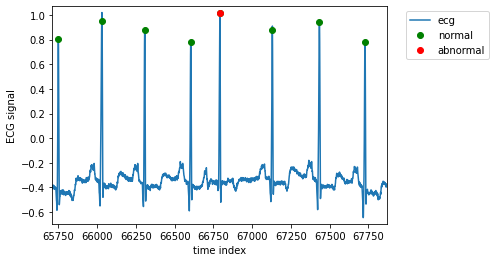

In [ ]:
left = ab_index[1]-1080
right = ab_index[1]+1080

plt.plot(x[left:right],p_signal[left:right,0],'-',label='ecg',)
plt.plot(x[atr_sample],p_signal[atr_sample,0],'go',label ='normal')
plt.plot(x[ab_index],p_signal[ab_index,0],'ro',label='abnormal')

plt.xlim(left,right)
plt.ylim(p_signal[left:right].min()-0.05,p_signal[left:right,0].max()+0.05)
plt.xlabel('time index')
plt.ylabel('ECG signal')
plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')
plt.show()


In [ ]:
def make_dataset(pts, num_sec, fs, abnormal):
    # function for making dataset ignoring non-beats
    # input:
    # pts - list of patients
    # num_sec = number of seconds to include before and after the beat
    # fs = frequency
    # output:
    #   X_all = signal (nbeats , num_sec * fs columns)
    #   Y_all = binary is abnormal (nbeats, 1)
    #   sym_all = beat annotation symbol (nbeats,1)

    # initialize numpy arrays
    num_cols = 2*num_sec * fs
    X_all = np.zeros((1,num_cols))
    Y_all = np.zeros((1,1))
    sym_all = []

    # list to keep track of number of beats across patients
    max_rows = []

    for pt in pts:
        file = data_path +'/'+ pt

        p_signal, atr_sym, atr_sample = load_ecg(file)

        # grab the first signal
        p_signal = p_signal[:,0]

        # make df to exclude the nonbeats
        df_ann = pd.DataFrame({'atr_sym':atr_sym,
                              'atr_sample':atr_sample})
        df_ann = df_ann.loc[df_ann.atr_sym.isin(abnormal + ['N'])]

        X,Y,sym = build_XY(p_signal,df_ann, num_cols, abnormal)
        sym_all = sym_all+sym
        max_rows.append(X.shape[0])
        X_all = np.append(X_all,X,axis = 0)
        Y_all = np.append(Y_all,Y,axis = 0)
    # drop the first zero row
    X_all = X_all[1:,:]
    Y_all = Y_all[1:,:]

    # check sizes make sense
    assert np.sum(max_rows) == X_all.shape[0], 'number of X, max_rows rows messed up'
    assert Y_all.shape[0] == X_all.shape[0], 'number of X, Y rows messed up'
    assert Y_all.shape[0] == len(sym_all), 'number of Y, sym rows messed up'

    return X_all, Y_all, sym_all



def build_XY(p_signal, df_ann, num_cols, abnormal):
    # this function builds the X,Y matrices for each beat
    # it also returns the original symbols for Y

    num_rows = len(df_ann)

    X = np.zeros((num_rows, num_cols))
    Y = np.zeros((num_rows,1))
    sym = []

    # keep track of rows
    max_row = 0

    for atr_sample, atr_sym in zip(df_ann.atr_sample.values,df_ann.atr_sym.values):

        left = max([0,(atr_sample - num_sec*fs) ])
        right = min([len(p_signal),(atr_sample + num_sec*fs) ])
        x = p_signal[left: right]
        if len(x) == num_cols:
            X[max_row,:] = x
            Y[max_row,:] = int(atr_sym in abnormal)
            sym.append(atr_sym)
            max_row += 1
    X = X[:max_row,:]
    Y = Y[:max_row,:]
    return X,Y,sym



In [ ]:
num_sec = 3
fs = 360



In [ ]:
X_all, Y_all, sym_all = make_dataset(pts, num_sec, fs, abnormal)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_all, Y_all, test_size=0.33, random_state=42)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.utils import to_categorical

In [ ]:
# build the same model
# lets test out relu (a different activation function) and add drop out (for regularization)
model = Sequential()
model.add(Dense(32, activation = 'relu', input_dim = X_train.shape[1]))
model.add(Dropout(rate = 0.25))
model.add(Dense(1, activation = 'sigmoid'))


In [ ]:
# compile the model - use categorical crossentropy, and the adam optimizer
model.compile(
                loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

In [ ]:
model.fit(X_train, y_train, batch_size = 32, epochs= 5, verbose = 1)

Epoch 1/5
2285/2285 [==============================] - 11s 4ms/step - loss: 0.2469 - accuracy: 0.9077
Epoch 2/5
2285/2285 [==============================] - 8s 3ms/step - loss: 0.1643 - accuracy: 0.9474
Epoch 3/5
2285/2285 [==============================] - 8s 3ms/step - loss: 0.1421 - accuracy: 0.9552
Epoch 4/5
2285/2285 [==============================] - 8s 3ms/step - loss: 0.1343 - accuracy: 0.9580
Epoch 5/5
2285/2285 [==============================] - 8s 3ms/step - loss: 0.1243 - accuracy: 0.9615


In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)
def print_report(y_actual, y_pred, thresh):

    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity

In [ ]:
y_train_preds_dense = model.predict(X_train,verbose = 1)
y_valid_preds_dense = model.predict(X_valid,verbose = 1)


1126/1126 [==============================] - 2s 2ms/step


In [ ]:
thresh = (sum(y_train)/len(y_train))[0]
thresh

0.3147641457808909

In [ ]:
print('Train');
print_report(y_train, y_train_preds_dense, thresh)
print('Valid');
print_report(y_valid, y_valid_preds_dense, thresh);

Train
AUC:0.992
accuracy:0.971
recall:0.958
precision:0.951
specificity:0.977
prevalence:0.315
 
Valid
AUC:0.988
accuracy:0.964
recall:0.949
precision:0.938
specificity:0.971
prevalence:0.314
 


In [ ]:
import random
random.seed( 42 )
pts_train = random.sample(pts, 36)
pts_valid = [pt for pt in pts if pt not in pts_train]
print(len(pts_train), len(pts_valid))


36 12


In [ ]:
X_train, y_train, sym_train = make_dataset(pts_train, num_sec, fs, abnormal)
X_valid, y_valid, sym_valid = make_dataset(pts_valid, num_sec, fs, abnormal)
print(X_train.shape, y_train.shape, len(sym_train))
print(X_valid.shape, y_valid.shape, len(sym_valid))


(80614, 2160) (80614, 1) 80614
(28485, 2160) (28485, 1) 28485


In [ ]:
# build the same model
# lets test out relu (a different activation function) and add drop out (for regularization)
model = Sequential()
model.add(Dense(32, activation = 'relu', input_dim = X_train.shape[1]))
model.add(Dropout(rate = 0.25))
model.add(Dense(1, activation = 'sigmoid'))

# compile the model - use categorical crossentropy, and the adam optimizer
model.compile(
                loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

model.fit(X_train, y_train, batch_size = 32, epochs= 5, verbose = 1)


Epoch 1/5
2520/2520 [==============================] - 9s 3ms/step - loss: 0.2261 - accuracy: 0.9197
Epoch 2/5
 393/2520 [===>..........................] - ETA: 6s - loss: 0.1465 - accuracy: 0.9545

KeyboardInterrupt: ignored

In [ ]:
y_train_preds_dense = model.predict(X_train,verbose = 1)
y_valid_preds_dense = model.predict(X_valid,verbose = 1)

891/891 [==============================] - 1s 1ms/step


In [ ]:
thresh = (sum(y_train)/len(y_train))[0]
thresh



0.29906715955045027

In [ ]:

print('Train');
print_report(y_train, y_train_preds_dense, thresh)
print('Valid');
print_report(y_valid, y_valid_preds_dense, thresh);


Train
AUC:0.994
accuracy:0.974
recall:0.957
precision:0.958
specificity:0.982
prevalence:0.299
 
Valid
AUC:0.818
accuracy:0.752
recall:0.460
precision:0.749
specificity:0.914
prevalence:0.358
 


In [ ]:
aucs_train = []
aucs_valid = []

n_pts = [1,18,36]
for n_pt in n_pts:

    print(n_pt)
    pts_sub = pts_train[:n_pt]
    X_sub, y_sub, sym_sub = make_dataset(pts_sub, num_sec, fs,abnormal)

    # build the same model
    # lets test out relu (a different activation function) and add drop out (for regularization)
    model = Sequential()
    model.add(Dense(32, activation = 'relu', input_dim = X_train.shape[1]))
    model.add(Dropout(rate = 0.25))
    model.add(Dense(1, activation = 'sigmoid'))

    # compile the model - use categorical crossentropy, and the adam optimizer
    model.compile(
                    loss = 'binary_crossentropy',
                    optimizer = 'adam',
                    metrics = ['accuracy'])

    model.fit(X_sub, y_sub, batch_size = 32, epochs= 5, verbose = 0)
    y_sub_preds_dense = model.predict(X_sub,verbose = 0)
    y_valid_preds_dense = model.predict(X_valid,verbose = 0)

    auc_train = roc_auc_score(y_sub, y_sub_preds_dense)
    auc_valid = roc_auc_score(y_valid, y_valid_preds_dense)
    print('-',auc_train, auc_valid)
    aucs_train.append(auc_train)
    aucs_valid.append(auc_valid)

1
- 0.9472748876853639 0.6913944753093786
18
- 0.9950666458398416 0.7806497733775843
36
- 0.9930592219452365 0.8613632552326409


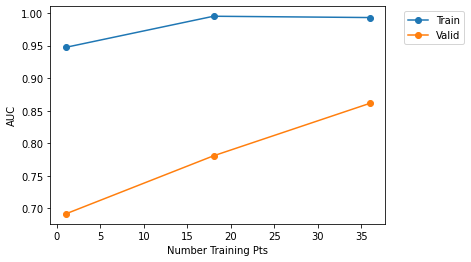

In [ ]:
plt.plot(n_pts, aucs_train, 'o-',label = 'Train')
plt.plot(n_pts, aucs_valid, 'o-',label = 'Valid')
plt.xlabel('Number Training Pts')
plt.ylabel('AUC')
plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')
plt.show()


CNN

In [ ]:
X_train_cnn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid_cnn = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

print(X_train_cnn.shape)
print(X_valid_cnn.shape)


(80614, 2160, 1)
(28485, 2160, 1)


In [ ]:

from keras.layers import Conv1D,Conv2D

In [ ]:
model = Sequential()
model.add(Conv1D(filters = 128, kernel_size = 5, activation = 'relu', input_shape = (2160,1)))
model.add(Dropout(rate = 0.25))
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))

# compile the model - use categorical crossentropy, and the adam optimizer
model.compile(
                loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])


In [ ]:
model.fit(X_train_cnn, y_train, batch_size = 32, epochs= 5, verbose = 1)

Epoch 1/5
2520/2520 [==============================] - 17s 3ms/step - loss: 0.1907 - accuracy: 0.9373
Epoch 2/5
2520/2520 [==============================] - 8s 3ms/step - loss: 0.1154 - accuracy: 0.9655
Epoch 3/5
2520/2520 [==============================] - 8s 3ms/step - loss: 0.0968 - accuracy: 0.9716
Epoch 4/5
2520/2520 [==============================] - 8s 3ms/step - loss: 0.0877 - accuracy: 0.9734
Epoch 5/5
2520/2520 [==============================] - 8s 3ms/step - loss: 0.0820 - accuracy: 0.9753


In [ ]:
y_train_preds_cnn = model.predict(X_train_cnn,verbose = 1)
y_valid_preds_cnn = model.predict(X_valid_cnn,verbose = 1)

891/891 [==============================] - 1s 1ms/step


In [ ]:
y_train_preds_cnn.shape

(80614, 1)

In [ ]:
print('Train');
print_report(y_train, y_train_preds_cnn, thresh)
print('Valid');
print_report(y_valid, y_valid_preds_cnn, thresh);


Train
AUC:0.995
accuracy:0.971
recall:0.974
precision:0.934
specificity:0.971
prevalence:0.299
 
Valid
AUC:0.928
accuracy:0.847
recall:0.838
precision:0.760
specificity:0.852
prevalence:0.358
 


LSTM


In [ ]:
from keras.layers import Bidirectional, LSTM,TimeDistributed,MaxPooling1D

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(64, input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2]))))
model.add(Dropout(rate = 0.5))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(
                loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 128)              33792     
 l)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 33,921
Trainable params: 33,921
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#model.fit(X_train_cnn[:10000], y_train[:10000], batch_size = 32, epochs= 5, verbose = 1)
model.fit(X_train_cnn, y_train, batch_size = 32, epochs= 10, verbose = 1)

Epoch 1/10
2520/2520 [==============================] - 292s 113ms/step - loss: 0.6047 - accuracy: 0.7047
Epoch 2/10
2520/2520 [==============================] - 287s 114ms/step - loss: 0.6053 - accuracy: 0.7023
Epoch 3/10
2520/2520 [==============================] - 287s 114ms/step - loss: 0.6036 - accuracy: 0.7002
Epoch 4/10
2520/2520 [==============================] - 287s 114ms/step - loss: 0.6006 - accuracy: 0.7053
Epoch 5/10
2520/2520 [==============================] - 286s 113ms/step - loss: 0.5958 - accuracy: 0.7066
Epoch 6/10
2520/2520 [==============================] - 285s 113ms/step - loss: 0.5925 - accuracy: 0.7047
Epoch 7/10
2520/2520 [==============================] - 286s 113ms/step - loss: 0.5861 - accuracy: 0.7090
Epoch 8/10
2520/2520 [==============================] - 284s 113ms/step - loss: 0.5756 - accuracy: 0.7124
Epoch 9/10
2520/2520 [==============================] - 284s 113ms/step - loss: 0.5731 - accuracy: 0.7083
Epoch 10/10
2520/2520 [=======================

In [ ]:
y_train_preds_lstm = model.predict(X_train_cnn,verbose = 1)
y_valid_preds_lstm = model.predict(X_valid_cnn,verbose = 1)


891/891 [==============================] - 45s 50ms/step


In [ ]:
print('Train');
print_report(y_train, y_train_preds_lstm, thresh)
print('Valid');
print_report(y_valid, y_valid_preds_lstm, thresh);


Train
AUC:0.615
accuracy:0.571
recall:0.679
precision:0.379
specificity:0.525
prevalence:0.299
 
Valid
AUC:0.504
accuracy:0.458
recall:0.803
precision:0.379
specificity:0.266
prevalence:0.358
 


CNN-LSTM


In [ ]:
import tensorflow as tf
model = Sequential()
model.add(Conv1D(filters = 128, kernel_size = 5, activation = 'relu', input_shape = (2160,1)))
model.add(MaxPooling1D(pool_size=2))


model.add(TimeDistributed(Flatten()))
#model.add(Bidirectional(LSTM(64, stateful=True,return_sequences=True)))

model.add(Dropout(rate = 0.25))
#model.add(LSTM(units=32, return_sequences=True, dropout=0.25))
#model.add(Bidirectional(LSTM(units=32, return_sequences=True, dropout=0.25)))
#model.add(Dropout(rate = 0.25))
model.add(Dense(1, activation = 'sigmoid'))



# compile the model - use categorical crossentropy, and the adam optimizer



In [ ]:

model.add(Bidirectional(LSTM(32, input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2]))))
model.add(Dropout(rate = 0.25))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(
                loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

In [ ]:
#model.fit(X_train_cnn[], y_train, epochs= 2)
model.fit(X_train_cnn, y_train, batch_size=32,epochs= 50,verbose=1)

Epoch 1/50
2520/2520 [==============================] - 172s 64ms/step - loss: 0.5966 - accuracy: 0.7073
Epoch 2/50
2520/2520 [==============================] - 160s 63ms/step - loss: 0.5921 - accuracy: 0.7139
Epoch 3/50
2520/2520 [==============================] - 161s 64ms/step - loss: 0.5842 - accuracy: 0.7217
Epoch 4/50
2520/2520 [==============================] - 162s 64ms/step - loss: 0.6039 - accuracy: 0.7077
Epoch 5/50
2520/2520 [==============================] - 162s 64ms/step - loss: 0.6138 - accuracy: 0.7009
Epoch 6/50
2520/2520 [==============================] - 162s 64ms/step - loss: 0.6103 - accuracy: 0.7009
Epoch 7/50
2520/2520 [==============================] - 160s 64ms/step - loss: 0.5948 - accuracy: 0.7051
Epoch 8/50
2520/2520 [==============================] - 161s 64ms/step - loss: 0.5999 - accuracy: 0.7032
Epoch 9/50
2520/2520 [==============================] - 162s 64ms/step - loss: 0.5980 - accuracy: 0.7007
Epoch 10/50
2520/2520 [==============================] 

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2156, 128)         768       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1078, 128)        0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 1078, 128)        0         
 ibuted)                                                         
                                                                 
 dropout (Dropout)           (None, 1078, 128)         0         
                                                                 
 dense (Dense)               (None, 1078, 1)           129       
                                                                 
 bidirectional (Bidirectiona  (None, 64)               8

In [ ]:
#y_train_preds_lstm = model.predict(X_train_cnn[:10000],verbose = 1)
#y_valid_preds_lstm = model.predict(X_valid_cnn,verbose = 1)
y_train_preds_cnn_lstm = model.predict(X_train_cnn,verbose=1)
y_valid_preds_cnn_lstm = model.predict(X_valid_cnn,verbose=1)


891/891 [==============================] - 31s 35ms/step


In [ ]:
#y_valid_preds_lstm=y_valid_preds_lstm.reshape(-1)

#y_train_preds_cnn_lstm=y_train_preds_cnn_lstm.reshape(86901892,1)
y_train_preds_cnn_lstm.shape

In [ ]:
#y_train_preds_lstm=y_train_preds_lstm.reshape(-1)
#y_valid_preds_lstm.shape
y_valid_preds_cnn_lstm.shape
#=y_valid_preds_cnn_lstm.reshape(30706830,1)

In [ ]:
print('Train');
print_report(y_train, y_train_preds_cnn_lstm, thresh)
print('Valid');
print_report(y_valid, y_valid_preds_cnn_lstm, thresh);

Train
AUC:0.868
accuracy:0.834
recall:0.651
precision:0.758
specificity:0.911
prevalence:0.299
 
Valid
AUC:0.459
accuracy:0.501
recall:0.214
precision:0.260
specificity:0.661
prevalence:0.358
 


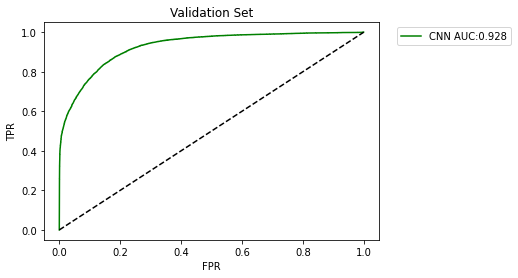

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score


fpr_valid_cnn, tpr_valid_cnn, t_valid_cnn = roc_curve(y_valid, y_valid_preds_cnn)
auc_valid_cnn = roc_auc_score(y_valid, y_valid_preds_cnn)

#fpr_valid_dense, tpr_valid_dense, t_valid_dense = roc_curve(y_valid, y_valid_preds_dense)
#auc_valid_dense = roc_auc_score(y_valid, y_valid_preds_dense)

#fpr_valid_lstm, tpr_valid_lstm, t_valid_lstm = roc_curve(y_valid, y_valid_preds_lstm)
#auc_valid_lstm = roc_auc_score(y_valid, y_valid_preds_lstm)

#fpr_valid_cnn_lstm, tpr_valid_cnn_lstm, t_valid_cnn_lstm = roc_curve(y_valid, y_valid_preds_cnn_lstm)
#auc_valid_cnn_lstm = roc_auc_score(y_valid, y_valid_preds_cnn_lstm)


plt.plot(fpr_valid_cnn, tpr_valid_cnn, 'g-', label = 'CNN AUC:%.3f'%auc_valid_cnn)
#plt.plot(fpr_valid_dense, tpr_valid_dense, 'r-', label = 'Dense AUC:%.3f'%auc_valid_dense)
#plt.plot(fpr_valid_lstm, tpr_valid_lstm, 'b-', label = 'LSTM AUC:%.3f'%auc_valid_lstm)
#plt.plot(fpr_valid_cnn_lstm, tpr_valid_cnn_lstm, 'h-', label = 'CNN-LSTM AUC:%.3f'%auc_valid_cnn_lstm)

plt.plot([0,1],[0,1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')
plt.title('Validation Set')
plt.show()